In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,random_split
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import random

In [2]:
IMG_SIZE=32
EMB_DIM=64
ATTENTION_HEAD=4
BATCH_SIZE=12
EPOCHS=100
LR=3e-4
TEMPERATURE=0.07

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#synthetic dataset properties
colors=["red","green","blue","yellow","purple","orange","pink","brown","gray"]
shapes=["square","circle","triangle"]
positions=["left","right","top","bottom","top-left","top-right","bottom-left","bottom-right"]

In [5]:
def draw_sample(color,shape,position,img_size=IMG_SIZE):
  img=Image.new('RGB',(img_size,img_size),'white')
  draw=ImageDraw.Draw(img)
  margin=6
  w=h=img_size-2*margin

  if 'left' in position:
    x0=margin
    x1=margin + w//2

  elif 'top-left' in position:
    x0=margin
    x1=margin + w//2

  elif 'bottom-left' in position:
    x0=margin
    x1=margin + w//2

  elif 'right' in position:
    x0=margin + w//2
    x1=img_size-margin

  elif 'top-right' in position:
    x0=margin + w//2
    x1=img_size-margin

  elif 'bottom-right' in position:
    x0=margin + w//2
    x1=img_size-margin

  else:
    x0=margin+w//4
    x1=margin+w*3//4
    #calculate y coordinate

  if 'top' in position:
    y0=margin
    y1=margin + h//2

  elif 'top-left' in position:
    y0=margin
    y1=margin + h//2

  elif 'top-right' in position:
    y0=margin
    y1=margin + h//2

  elif 'bottom' in position:
    y0=margin + h//2
    y1=img_size-margin

  elif 'bottom-left' in position:
    y0=margin + h//2
    y1=img_size-margin

  elif 'bottom-right' in position:
    y0=margin + h//2
    y1=img_size-margin

  else:
    y0=margin+h//4
    y1=margin+h*3//4

  if shape=='square':
    draw.rectangle((x0,y0,x1,y1),fill=color,outline='black')

  elif shape=='circle':
    draw.ellipse((x0,y0,x1,y1),fill=color,outline='black')

  else:
    draw.polygon([(x0+(x1-x0)//2,y0),(x0,y1),(x1,y1)],fill=color, outline='black')

  return img



In [6]:
class ShapesDataset:
  def __init__(self):
    self.images=[]
    self.captions=[]

    for c in colors:
      for s in shapes:
        for p in positions:
          img=draw_sample(c,s,p)
          caption=f"{c} {s} {p}"
          self.images.append(torch.from_numpy(np.array(img)).permute(2,0,1).float()/255.0)
          self.captions.append(caption)

    self.vocab,self.word2idx=self.build_vocab(self.captions)

  def build_vocab(self,texts):
    unique_words = set()
    for t in texts:
      for w in t.split():
        unique_words.add(w)
    words = sorted(list(unique_words))
    all_words_for_idx = ['[CLS]'] + words
    word2idx = {w:i for i,w in enumerate(all_words_for_idx)}
    vocab = all_words_for_idx 

    return vocab,word2idx

  def encoder(self,text):
    tokens=[self.word2idx['[CLS]']]+ [self.word2idx[w] for w in text.split()]
    return torch.tensor(tokens,dtype=torch.long)

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    return self.images[idx],self.encoder(self.captions[idx])

In [7]:
dataset=ShapesDataset()
VOCAB_SIZE=len(dataset)
print(VOCAB_SIZE)

216


In [8]:
print(dataset.vocab)

['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


In [9]:
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_ds, test_ds= random_split(dataset,[train_size,test_size])

In [10]:
train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False)

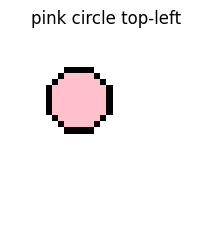

In [11]:
imgs, caps=next(iter(train_loader))
idx=random.randint(0,len(imgs)-1)
img=imgs[idx]
caption_tensor=caps[idx]

img_to_display=(img.permute(1,2,0).numpy()*255).astype(np.uint8)

caption_words = [dataset.vocab[i] for i in caption_tensor.tolist()]
caption_str = " ".join(caption_words[1:]) # Skip '[CLS]' token for display

plt.figure(figsize=(2.5,2.5))
plt.imshow(img_to_display)
plt.title(caption_str)
plt.axis('off')
plt.show()

In [12]:
from torch.nn.modules.conv import Conv2d
class ImageEncoder(nn.Module):
  def __init__(self,emb_dim=EMB_DIM):
    super().__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1),
        nn.ReLU()
      )

    self.projection=nn.Linear(256,EMB_DIM)
    self.layer_norm=nn.LayerNorm(EMB_DIM)


  def forward(self,x):
    x=self.conv(x)
    x=x.mean(dim=[2,3])
    x=self.projection(x)
    x=F.normalize(self.layer_norm(x),dim=-1)
    return x


In [13]:
class TextEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_emb=nn.Embedding(VOCAB_SIZE,EMB_DIM)
    self.position_emb=nn.Embedding(5,EMB_DIM) #context window =4
    self.mha=nn.MultiheadAttention(EMB_DIM,ATTENTION_HEAD,batch_first=True)
    self.layer_norm=nn.LayerNorm(EMB_DIM)
    self.projection=nn.Linear(EMB_DIM,EMB_DIM)

  def forward(self,tokens):
    N,L=tokens.shape
    position_emb_ids=torch.arange(L,device=device).unsqueeze(0).expand(N,L)
    position_emb_vec=self.position_emb(position_emb_ids)
    token_emb_vec=self.token_emb(tokens)
    final_emb=token_emb_vec+position_emb_vec
    context_vector=self.mha(final_emb,final_emb,final_emb)[0]
    x=context_vector[:,0]
    projection=self.projection(x)
    return F.normalize(self.layer_norm(projection),dim=-1)


In [14]:
def clip_loss(img_emb,text_emb,temperature=TEMPERATURE):
  logits=logits = (img_emb @ text_emb.T) / temperature
  targets=torch.arange(len(img_emb),device=device)
  loss_i=F.cross_entropy(logits,targets)
  loss_t=F.cross_entropy(logits.T,targets)
  return (loss_i+loss_t)/2.0

In [15]:
img_enc=ImageEncoder().to(device)
text_enc=TextEncoder().to(device)
params=list(img_enc.parameters())+list(text_enc.parameters())
optimizer=torch.optim.Adam(params,lr=LR)

In [16]:
from tqdm.auto import tqdm

def train_epoch(image_encoder, text_encoder, train_dataloader, optimizer, temperature, device):
    image_encoder.train()
    text_encoder.train()
    total_loss = 0
    for imgs, caps in tqdm(train_dataloader, desc="Training"):
        imgs = imgs.to(device)
        caps = caps.to(device)

        img_emb = image_encoder(imgs)
        text_emb = text_encoder(caps)
        loss = clip_loss(img_emb, text_emb, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_dataloader)

def validate_epoch(image_encoder, text_encoder, val_dataloader, temperature, device):
    image_encoder.eval()
    text_encoder.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, caps in tqdm(val_dataloader, desc="Validation"):
            imgs = imgs.to(device)
            caps = caps.to(device)

            img_emb = image_encoder(imgs)
            text_emb = text_encoder(caps)
            loss = clip_loss(img_emb, text_emb, temperature)
            total_loss += loss.item()
    return total_loss / len(val_dataloader)

train_losses = []
val_losses = []

print(f"{'Epoch':<10}{'Train Loss':<15}{'Val Loss':<15}")
print("-" * 40)

for epoch in range(EPOCHS):
    train_loss = train_epoch(img_enc, text_enc, train_loader, optimizer, TEMPERATURE, device)
    val_loss = validate_epoch(img_enc, text_enc, test_loader, TEMPERATURE, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"{epoch+1:<10}{train_loss:<15.4f}{val_loss:<15.4f}")


c:\miniconda\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch     Train Loss     Val Loss       
----------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00, 179.07it/s]


1         2.3666         2.2065         


Validation: 100%|██████████| 4/4 [00:00<00:00, 331.37it/s]


2         1.6219         1.2221         


Validation: 100%|██████████| 4/4 [00:00<00:00, 266.28it/s]



3         0.9172         0.6491         


Validation: 100%|██████████| 4/4 [00:00<00:00, 366.93it/s]



4         0.6593         0.5628         


Validation: 100%|██████████| 4/4 [00:00<00:00, 322.34it/s]



5         0.4704         0.9552         


Validation: 100%|██████████| 4/4 [00:00<00:00, 300.86it/s]



6         0.5985         0.5022         


Validation: 100%|██████████| 4/4 [00:00<00:00, 305.98it/s]


7         0.4518         0.5697         


Validation: 100%|██████████| 4/4 [00:00<00:00, 318.96it/s]


8         0.4486         0.4448         


Validation: 100%|██████████| 4/4 [00:00<00:00, 297.60it/s]


9         0.3668         0.4298         


Validation: 100%|██████████| 4/4 [00:00<00:00, 375.92it/s]


10        0.4274         0.3605         


Validation: 100%|██████████| 4/4 [00:00<00:00, 345.17it/s]



11        0.4329         0.3678         


Validation: 100%|██████████| 4/4 [00:00<00:00, 248.53it/s]


12        0.2678         0.3913         


Validation: 100%|██████████| 4/4 [00:00<00:00, 271.97it/s]



13        0.2788         0.2671         


Validation: 100%|██████████| 4/4 [00:00<00:00, 324.10it/s]



14        0.2396         0.3364         


Validation: 100%|██████████| 4/4 [00:00<00:00, 347.00it/s]



15        0.3114         0.5069         


Validation: 100%|██████████| 4/4 [00:00<00:00, 262.51it/s]


16        0.2931         0.3500         


Validation: 100%|██████████| 4/4 [00:00<00:00, 270.53it/s]


17        0.1916         0.2694         


Validation: 100%|██████████| 4/4 [00:00<00:00, 258.81it/s]


18        0.1923         0.2428         


Validation: 100%|██████████| 4/4 [00:00<00:00, 259.40it/s]


19        0.1498         0.2504         


Validation: 100%|██████████| 4/4 [00:00<00:00, 331.30it/s]



20        0.1498         0.2079         


Validation: 100%|██████████| 4/4 [00:00<00:00, 333.62it/s]



21        0.1212         0.2011         


Validation: 100%|██████████| 4/4 [00:00<00:00, 396.36it/s]



22        0.2176         0.1870         


Validation: 100%|██████████| 4/4 [00:00<00:00, 320.84it/s]


23        0.1843         0.1962         


Validation: 100%|██████████| 4/4 [00:00<00:00, 293.62it/s]


24        0.1018         0.1979         


Validation: 100%|██████████| 4/4 [00:00<00:00, 323.67it/s]


25        0.0978         0.1551         


Validation: 100%|██████████| 4/4 [00:00<00:00, 282.39it/s]


26        0.1000         0.1239         


Validation: 100%|██████████| 4/4 [00:00<00:00, 301.82it/s]


27        0.1059         0.1653         


Validation: 100%|██████████| 4/4 [00:00<00:00, 362.92it/s]


28        0.1424         0.2258         


Validation: 100%|██████████| 4/4 [00:00<00:00, 362.65it/s]



29        0.1286         0.1463         


Validation: 100%|██████████| 4/4 [00:00<00:00, 266.36it/s]



30        0.0894         0.0983         


Validation: 100%|██████████| 4/4 [00:00<00:00, 272.43it/s]


31        0.0972         0.1254         


Validation: 100%|██████████| 4/4 [00:00<00:00, 288.50it/s]


32        0.0430         0.1164         


Validation: 100%|██████████| 4/4 [00:00<00:00, 377.72it/s]



33        0.0550         0.0995         


Validation: 100%|██████████| 4/4 [00:00<00:00, 307.02it/s]


34        0.0407         0.0774         


Validation: 100%|██████████| 4/4 [00:00<00:00, 325.16it/s]



35        0.0441         0.0694         


Validation: 100%|██████████| 4/4 [00:00<00:00, 233.54it/s]


36        0.0440         0.0730         


Validation: 100%|██████████| 4/4 [00:00<00:00, 279.51it/s]


37        0.0289         0.0750         


Validation: 100%|██████████| 4/4 [00:00<00:00, 362.17it/s]



38        0.0326         0.0824         


Validation: 100%|██████████| 4/4 [00:00<00:00, 347.55it/s]


39        0.0564         0.1086         


Validation: 100%|██████████| 4/4 [00:00<00:00, 373.51it/s]



40        0.0803         0.1775         


Validation: 100%|██████████| 4/4 [00:00<00:00, 327.62it/s]


41        0.0623         0.1230         


Validation: 100%|██████████| 4/4 [00:00<00:00, 284.85it/s]


42        0.0666         0.0741         


Validation: 100%|██████████| 4/4 [00:00<00:00, 265.99it/s]



43        0.0406         0.0696         


Validation: 100%|██████████| 4/4 [00:00<00:00, 233.41it/s]


44        0.0412         0.0681         


Validation: 100%|██████████| 4/4 [00:00<00:00, 283.80it/s]



45        0.0564         0.1885         


Validation: 100%|██████████| 4/4 [00:00<00:00, 297.39it/s]



46        0.0724         0.0757         


Validation: 100%|██████████| 4/4 [00:00<00:00, 265.12it/s]


47        0.0554         0.0630         


Validation: 100%|██████████| 4/4 [00:00<00:00, 321.02it/s]


48        0.0337         0.1425         


Validation: 100%|██████████| 4/4 [00:00<00:00, 324.39it/s]


49        0.0678         0.2900         


Validation: 100%|██████████| 4/4 [00:00<00:00, 294.89it/s]


50        0.0593         0.1077         


Validation: 100%|██████████| 4/4 [00:00<00:00, 347.17it/s]


51        0.0575         0.0608         


Validation: 100%|██████████| 4/4 [00:00<00:00, 256.36it/s]


52        0.0346         0.0771         


Validation: 100%|██████████| 4/4 [00:00<00:00, 266.21it/s]


53        0.0222         0.0605         


Validation: 100%|██████████| 4/4 [00:00<00:00, 351.01it/s]



54        0.0359         0.0375         


Validation: 100%|██████████| 4/4 [00:00<00:00, 284.45it/s]


55        0.0287         0.0405         


Validation: 100%|██████████| 4/4 [00:00<00:00, 250.69it/s]


56        0.0365         0.0785         


Validation: 100%|██████████| 4/4 [00:00<00:00, 264.02it/s]



57        0.0273         0.0391         


Validation: 100%|██████████| 4/4 [00:00<00:00, 209.59it/s]


58        0.0274         0.0366         


Validation: 100%|██████████| 4/4 [00:00<00:00, 319.69it/s]



59        0.0329         0.0344         


Validation: 100%|██████████| 4/4 [00:00<00:00, 304.71it/s]



60        0.0206         0.0370         


Validation: 100%|██████████| 4/4 [00:00<00:00, 305.07it/s]



61        0.0200         0.0344         


Validation: 100%|██████████| 4/4 [00:00<00:00, 226.32it/s]


62        0.0210         0.0566         


Validation: 100%|██████████| 4/4 [00:00<00:00, 217.67it/s]


63        0.0300         0.0340         


Validation: 100%|██████████| 4/4 [00:00<00:00, 301.43it/s]


64        0.0256         0.0336         


Validation: 100%|██████████| 4/4 [00:00<00:00, 179.52it/s]


65        0.0215         0.0621         


Validation: 100%|██████████| 4/4 [00:00<00:00, 189.88it/s]


66        0.0294         0.0400         


Validation: 100%|██████████| 4/4 [00:00<00:00, 210.62it/s]


67        0.0354         0.1569         


Validation: 100%|██████████| 4/4 [00:00<00:00, 315.13it/s]



68        0.0432         0.0947         


Validation: 100%|██████████| 4/4 [00:00<00:00, 206.91it/s]


69        0.0292         0.0535         


Validation: 100%|██████████| 4/4 [00:00<00:00, 270.40it/s]


70        0.0334         0.1325         


Validation: 100%|██████████| 4/4 [00:00<00:00, 333.00it/s]


71        0.0557         0.0900         


Validation: 100%|██████████| 4/4 [00:00<00:00, 333.20it/s]


72        0.0751         0.0852         


Validation: 100%|██████████| 4/4 [00:00<00:00, 289.93it/s]


73        0.0521         0.0528         


Validation: 100%|██████████| 4/4 [00:00<00:00, 245.53it/s]


74        0.0179         0.0360         


Validation: 100%|██████████| 4/4 [00:00<00:00, 294.55it/s]


75        0.0252         0.0429         


Validation: 100%|██████████| 4/4 [00:00<00:00, 279.55it/s]


76        0.0373         0.0351         


Validation: 100%|██████████| 4/4 [00:00<00:00, 227.50it/s]



77        0.0231         0.0490         


Validation: 100%|██████████| 4/4 [00:00<00:00, 274.42it/s]



78        0.0348         0.0575         


Validation: 100%|██████████| 4/4 [00:00<00:00, 351.69it/s]



79        0.0288         0.0347         


Validation: 100%|██████████| 4/4 [00:00<00:00, 396.86it/s]


80        0.0183         0.0332         


Validation: 100%|██████████| 4/4 [00:00<00:00, 221.40it/s]



81        0.0178         0.0360         


Training: 100%|██████████| 15/15 [00:00<00:00, 100.64it/s]

Validation: 100%|██████████| 4/4 [00:00<00:00, 256.06it/s]


82        0.0175         0.0259         


Validation: 100%|██████████| 4/4 [00:00<00:00, 262.92it/s]



83        0.0169         0.0294         


Validation: 100%|██████████| 4/4 [00:00<00:00, 346.34it/s]


84        0.0162         0.0275         


Validation: 100%|██████████| 4/4 [00:00<00:00, 342.70it/s]



85        0.0207         0.0250         


Validation: 100%|██████████| 4/4 [00:00<00:00, 293.61it/s]



86        0.0132         0.0260         


Validation: 100%|██████████| 4/4 [00:00<00:00, 362.73it/s]



87        0.0194         0.0336         


Validation: 100%|██████████| 4/4 [00:00<00:00, 285.02it/s]


88        0.0166         0.0243         


Validation: 100%|██████████| 4/4 [00:00<00:00, 395.05it/s]



89        0.0164         0.0270         


Validation: 100%|██████████| 4/4 [00:00<00:00, 361.19it/s]



90        0.0184         0.0244         


Validation: 100%|██████████| 4/4 [00:00<00:00, 294.39it/s]


91        0.0180         0.0259         


Validation: 100%|██████████| 4/4 [00:00<00:00, 288.80it/s]


92        0.0099         0.0299         


Validation: 100%|██████████| 4/4 [00:00<00:00, 306.25it/s]


93        0.0105         0.0310         


Validation: 100%|██████████| 4/4 [00:00<00:00, 359.31it/s]


94        0.0096         0.0266         


Validation: 100%|██████████| 4/4 [00:00<00:00, 238.02it/s]


95        0.0115         0.0325         


Validation: 100%|██████████| 4/4 [00:00<00:00, 312.15it/s]


96        0.0189         0.0345         


Validation: 100%|██████████| 4/4 [00:00<00:00, 337.67it/s]



97        0.0278         0.0254         


Validation: 100%|██████████| 4/4 [00:00<00:00, 305.81it/s]


98        0.0254         0.1407         


Validation: 100%|██████████| 4/4 [00:00<00:00, 265.94it/s]


99        0.0494         0.0368         


Validation: 100%|██████████| 4/4 [00:00<00:00, 418.46it/s]

100       0.0432         0.0724         


In [17]:
all_img_embeddings = []
all_text_embeddings = []

img_enc.eval()
text_enc.eval()

with torch.no_grad():
    for i in range(len(dataset)):
        img, caption = dataset[i]


        img = img.unsqueeze(0).to(device)
        img_emb = img_enc(img).cpu().numpy()
        all_img_embeddings.append(img_emb)


        caption = caption.unsqueeze(0).to(device)
        text_emb = text_enc(caption).cpu().numpy()
        all_text_embeddings.append(text_emb)

# Concatenate all embeddings into single NumPy arrays
all_img_embeddings_np = np.concatenate(all_img_embeddings, axis=0)
all_text_embeddings_np = np.concatenate(all_text_embeddings, axis=0)

print(f"Shape of all_img_embeddings_np: {all_img_embeddings_np.shape}")
print(f"Shape of all_text_embeddings_np: {all_text_embeddings_np.shape}")

Shape of all_img_embeddings_np: (216, 64)
Shape of all_text_embeddings_np: (216, 64)


In [18]:
def text_to_image_retrieval(text_query, k=5):
    tokenized_query = dataset.encoder(text_query).to(device)
    text_embedding = text_enc(tokenized_query.unsqueeze(0))
    img_embeddings_tensor = torch.from_numpy(all_img_embeddings_np).to(device)
    similarities = (text_embedding @ img_embeddings_tensor.T).squeeze(0)

    top_k_scores, top_k_indices = torch.topk(similarities, k=k)

    return top_k_indices.cpu().detach().numpy(), top_k_scores.cpu().detach().numpy()

Text Query: 'red square left'
Top 5 retrieved images:


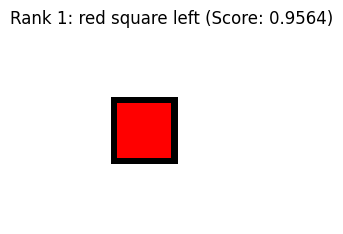

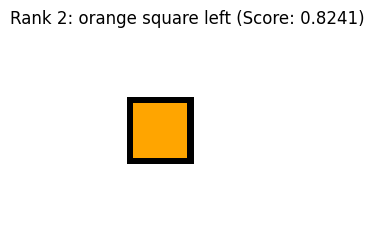

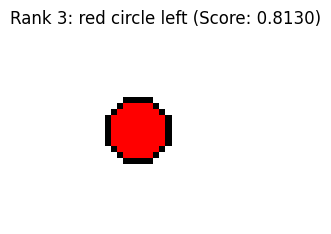

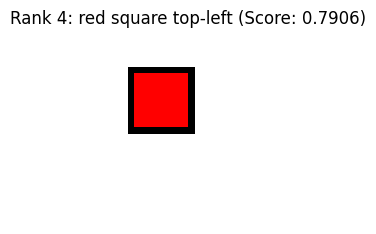

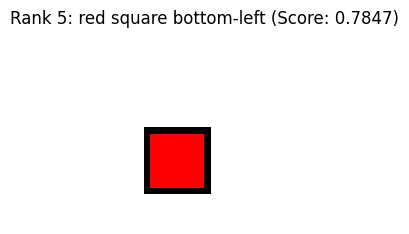

In [19]:
text_query = "red square left"
top_k_indices, top_k_scores = text_to_image_retrieval(text_query, k=5)

print(f"Text Query: '{text_query}'")
print("Top 5 retrieved images:")
for i, (idx, score) in enumerate(zip(top_k_indices, top_k_scores)):
    img_tensor, caption_tensor = dataset[idx]
    img_to_display = (img_tensor.permute(1,2,0).numpy()*255).astype(np.uint8)
    caption_words = [dataset.vocab[w_idx] for w_idx in caption_tensor.tolist()]
    caption_str = " ".join(caption_words[1:]) # Skip '[CLS]' token

    plt.figure(figsize=(2.5,2.5))
    plt.imshow(img_to_display)
    plt.title(f"Rank {i+1}: {caption_str} (Score: {score:.4f})")
    plt.axis('off')
    plt.show()

In [20]:
def image_to_text_retrieval(image_index, k=5):
    img_tensor, _ = dataset[image_index]
    img_embedding = img_enc(img_tensor.unsqueeze(0).to(device))
    text_embeddings_tensor = torch.from_numpy(all_text_embeddings_np).to(device)
    similarities = (img_embedding @ text_embeddings_tensor.T).squeeze(0);

    top_k_scores, top_k_indices = torch.topk(similarities, k=k)

    return top_k_indices.cpu().detach().numpy(), top_k_scores.cpu().detach().numpy()

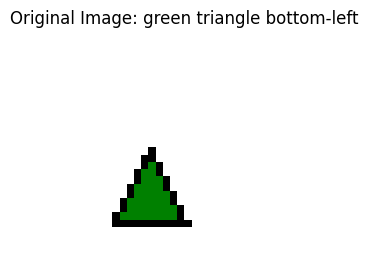


Top 5 retrieved captions for image 'green triangle bottom-left':
Rank 1: green triangle bottom-left (Score: 0.8577)
Rank 2: blue triangle bottom-left (Score: 0.7827)
Rank 3: green circle bottom-left (Score: 0.6727)
Rank 4: green square bottom-left (Score: 0.6619)
Rank 5: blue circle bottom-left (Score: 0.6234)


In [21]:
random_image_index = random.randint(0, len(dataset) - 1)

top_k_indices, top_k_scores = image_to_text_retrieval(random_image_index, k=5)

original_img_tensor, original_caption_tensor = dataset[random_image_index]
original_img_to_display = (original_img_tensor.permute(1,2,0).numpy()*255).astype(np.uint8)
original_caption_words = [dataset.vocab[w_idx] for w_idx in original_caption_tensor.tolist()]
original_caption_str = " ".join(original_caption_words[1:])

plt.figure(figsize=(3,3))
plt.imshow(original_img_to_display)
plt.title(f"Original Image: {original_caption_str}")
plt.axis('off')
plt.show()

print(f"\nTop 5 retrieved captions for image '{original_caption_str}':")
for i, (idx, score) in enumerate(zip(top_k_indices, top_k_scores)):
    retrieved_caption_tensor = dataset.captions[idx]
    # The dataset.encoder output includes [CLS], so we need to get the original caption string
    retrieved_caption_str = " ".join([dataset.vocab[w_idx] for w_idx in dataset.encoder(retrieved_caption_tensor).tolist()][1:])
    print(f"Rank {i+1}: {retrieved_caption_str} (Score: {score:.4f})")